### Regressogram test

I'll implement CLMM solution first and then change it to compare to other statistics

### Preparing necessary libraries

In [1]:
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import timedelta
from astropy import units
from numpy import random
plt.rcParams['text.latex.preamble'] = [r'\usepackage{pxfonts, mathpazo}']
plt.rcParams['font.family']=['Palatino']
plt.rc('text', usetex=True)


import clmm.dataops as da
import clmm.theory as theory
from clmm import Cosmology
from clmm.support import mock_data as mock
from clmm.utils import convert_units
from scipy.stats import chi2
from scipy.stats import kstest
import corner
import math

### Creating mock data

In [55]:
np.random.seed(0)

# Define cosmological parameters
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)
    
cluster_m     = 1.e15 # Cluster mass
cluster_z     = 0.4   # Cluster redshift
concentration = 4     # Concentrion parameter NFW profile
ngals         = 10000 # Number of galaxies
Delta         = 200   # Overdensity parameter definition NFW profile
cluster_ra    = 0.0   # Cluster right ascension
cluster_dec   = 0.0   # Cluster declination
shapenoise    = 1 # True ellipticity standard variation

# Create galaxy catalog and Cluster object
data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 0.9, shapenoise=shapenoise, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
gc = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data)

gc.compute_tangential_and_cross_components(geometry="flat")
radius = convert_units(gc.galcat['theta'], 'radians', 'Mpc', redshift=gc.z, cosmo=cosmo)

# Create binning profile por binned methods
nbins = 50
bin_edges = da.make_bins(0.7, 4, nbins)
profile = gc.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo, gal_ids_in_bins=True)

/home/caiooliveira/.local/lib/python3.10/site-packages/clmm-1.4.0-py3.10.egg/clmm/support/mock_data.py:208: UserWarning: Not able to remove 506 aphysical objects after 5 iterations
/home/caiooliveira/.local/lib/python3.10/site-packages/clmm-1.4.0-py3.10.egg/clmm/utils.py:174: RuntimeWarning: invalid value encountered in sqrt
  err_y = np.sqrt(stat_yerr2+data_yerr2)


In [ ]:
# np.random.seed(11)
# # comment
# cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

# cluster_m     = 1.e15
# logm = np.log(cluster_m)/np.log(10)
# cluster_z     = 0.4
# concentration = 4
# ngals         = 10000
# Delta         = 200
# cluster_ra    = 0.0
# cluster_dec   = 0.0

# shapenoise = 1e-3

# ideal_data   = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 0.8, zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
# ideal_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo,'chang13', zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
# noisy_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 'chang13', zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, photoz_sigma_unscaled=0.05, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)

# gc_ideal   = clmm.GalaxyCluster("CL_ideal", cluster_ra, cluster_dec, cluster_z, ideal_data)
# gc_ideal_z = clmm.GalaxyCluster("CL_ideal_z", cluster_ra, cluster_dec, cluster_z, ideal_data_z)
# gc_noisy_z = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, noisy_data_z)


### Calculating observables

In [ ]:
# theta_ideal, gt_ideal, gx_ideal       = gc_ideal.compute_tangential_and_cross_components(geometry="flat")
# theta_ideal_z, gt_ideal_z, gx_ideal_z = gc_ideal_z.compute_tangential_and_cross_components(geometry="flat")
# theta_noisy_z, gt_noisy_z, gx_noisy_z = gc_noisy_z.compute_tangential_and_cross_components(geometry="flat")

### Binning the data

In [ ]:
# bin_edges = da.make_bins(0.7, 4, 15, method='evenlog10width')

# profile_ideal   = gc_ideal.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo, gal_ids_in_bins=True)
# profile_ideal_z = gc_ideal_z.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo, gal_ids_in_bins=True)
# profile_noisy_z = gc_noisy_z.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo, gal_ids_in_bins=True)

### Plotting binned data

In [56]:
fig, ax = plt.subplots(nbins, 2, figsize=(12,2*nbins), dpi=300, facecolor="white")

gc_theta = []
gc_gt    = []
gc_z     = []


for j in range(len(gc.profile)):
    gc_theta.append([gc.galcat['theta'][gal_id] for gal_id in gc.profile[j]['gal_id']])
    gc_gt.append([gc.galcat['et'][gal_id] for gal_id in gc.profile[j]['gal_id']])
    gc_z.append([gc.galcat['z'][gal_id] for gal_id in gc.profile[j]['gal_id']])

for bin_i, ax_i in zip(range(nbins), range(nbins)):
    N_i = len(gc.profile[bin_i]['gal_id'])
    radius = convert_units(gc_theta[bin_i], 'radians', 'Mpc', redshift=gc.z, cosmo=cosmo)
    shear = clmm.compute_reduced_tangential_shear(radius, cluster_m, concentration, gc.z, gc_z[bin_i], cosmo, delta_mdef=200, halo_profile_model='nfw')


    # ax[ax_i][0].hist(gc_theta[bin_i], bins=30, color='tab:red', label=f'Bin ${bin_i+1}$, $N_{{gals}} = {N_i}$', alpha=0.8)
    ax[ax_i][0].hist(shear, bins=30, color='tab:red', label=f'Bin ${bin_i+1}$, $N_{{gals}} = {N_i}$', alpha=0.8)
    ax[ax_i][1].hist(gc_z[bin_i], bins=30, color='tab:blue', label=f'Bin ${bin_i+1}$, $N_{{gals}} = {N_i}$', alpha=0.8)

    # ax[ax_i][0].set_xlabel(f'Angular radius ($\\theta$)', fontsize='20')
    ax[ax_i][0].set_xlabel(f'Tangential observed ellipticity ($\\epsilon_t^{{(obs)}}$)', fontsize='20')
    ax[ax_i][1].set_xlabel(f'Redshift ($z$)', fontsize='20')

    # ax[ax_i][0].set_ylabel(f'Number of ocurrences', fontsize='20')
    ax[ax_i][0].set_ylabel(f'Number of ocurrences', fontsize='20')
    ax[ax_i][1].set_ylabel(f'Number of ocurrences', fontsize='20')

    # ax[ax_i][0].legend(fontsize=12)
    ax[ax_i][0].legend(fontsize=12)
    ax[ax_i][1].legend(fontsize=12)

# fig.suptitle(f'Histograms of $\\epsilon_t^{{(obs)}}$, and $z$', fontsize='50', weight='bold')

fig.tight_layout()
# fig.subplots_adjust(top=0.98)

TypeError: 'float' object is not iterable

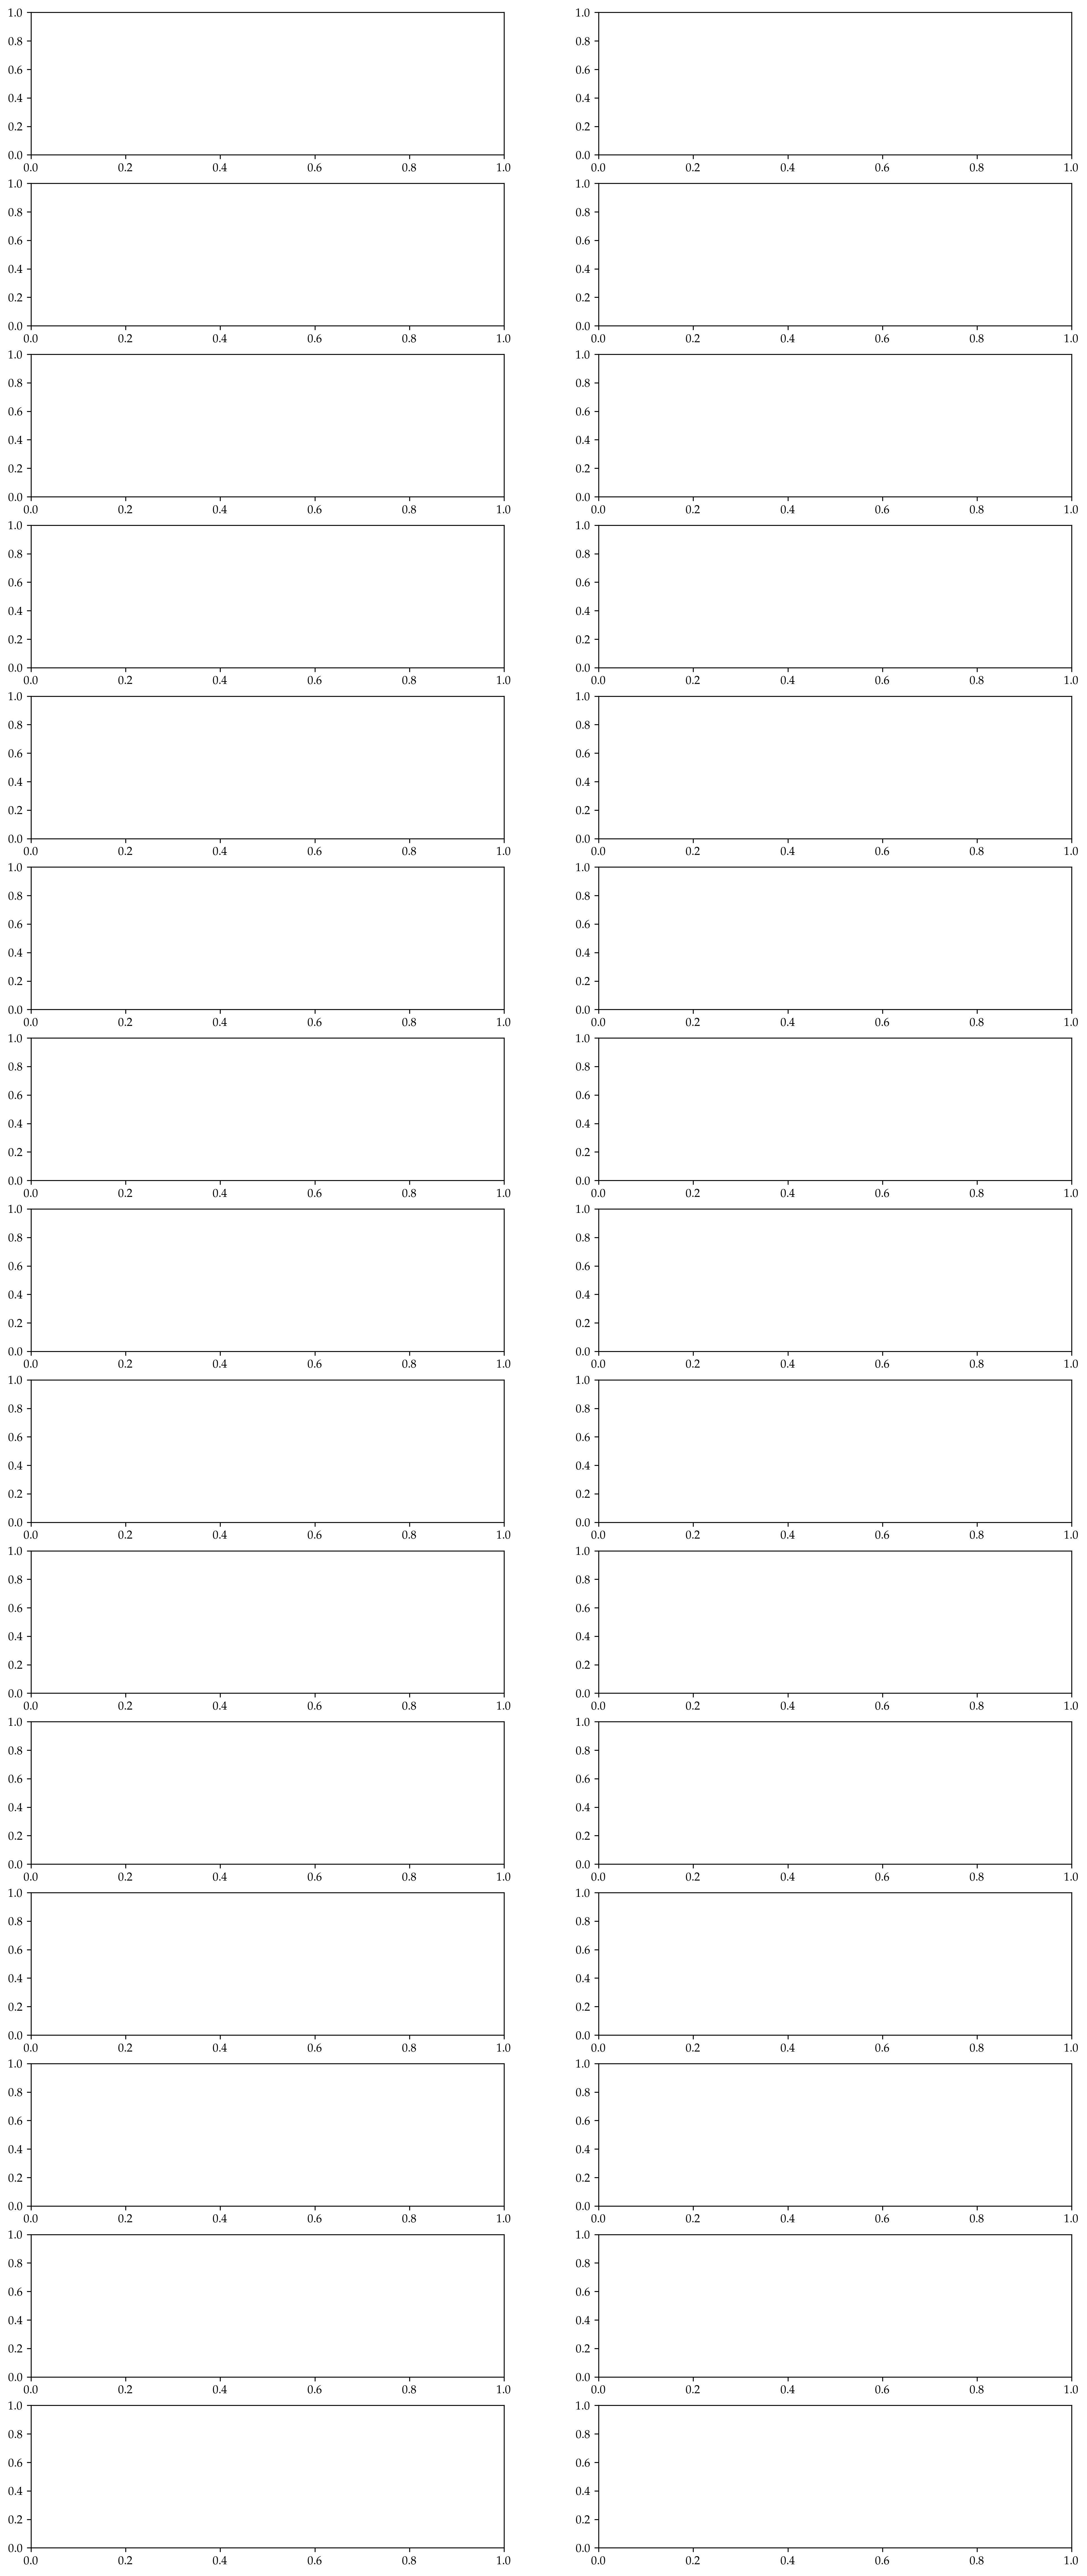

In [27]:
plt.rc('text', usetex=True)

fig, ax = plt.subplots(15, 2, figsize=(16,40), dpi=300, facecolor="white")

# gc_theta = []
gc_gt    = []
gc_z     = []

for j in range(len(gc.profile)):
    # gc_theta.append([gc.galcat['theta'][gal_id] for gal_id in gc.profile[j]['gal_id']])
    gc_gt.append([gc.galcat['et'][gal_id] for gal_id in gc.profile[j]['gal_id']])
    gc_z.append([gc.galcat['z'][gal_id] for gal_id in gc.profile[j]['gal_id']])

for bin_i, ax_i in zip(range(15), range(15)):
    N_i = len(gc.profile[bin_i]['gal_id'])
    radius = convert_units(gc_theta[bin_i], 'radians', 'Mpc', redshift=gc.z, cosmo=cosmo)
    shear = clmm.compute_reduced_tangential_shear(radius, cluster_m, concentration, gc.z, gc_z[bin_i], cosmo, delta_mdef=200, halo_profile_model='nfw')

    # theta_kde = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
    # theta_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)
    # for th in gc_theta[bin_i]:
    #     theta_kde.add_obs(th)
    #     theta_kde_rot.add_obs(th)
    # theta_kde.prepare()
    # theta_kde_rot.prepare()

    # x = np.linspace(min(gc_theta[bin_i]), max(gc_theta[bin_i]), num=1000)
    # y = [theta_kde.eval_p(xi) for xi in x]
    # t = [theta_kde_rot.eval_p(xi) for xi in x]

    # ax[ax_i][0].hist(gc_theta[bin_i], bins=30, density=True, color='tab:red', label=f'Bin ${bin_i+1}$, $N_{{gals}} = {N_i}$', alpha=0.8)
    # ax[ax_i][0].plot(x, y, color='tab:purple', label='KDE Auto', linewidth=5, alpha=0.8)
    # ax[ax_i][0].plot(x, t, color='tab:orange', label='KDE RoT', linewidth=5, alpha=0.8)


    gt_kde = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
    gt_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)
    for gt in shear[bin_i]:
        gt_kde.add_obs(gt)
        gt_kde_rot.add_obs(gt)
    gt_kde.prepare()
    gt_kde_rot.prepare()

    x = np.linspace(min(shear[bin_i]), max(shear[bin_i]), num=1000)
    y = [gt_kde.eval_p(xi) for xi in x]
    t = [gt_kde_rot.eval_p(xi) for xi in x]

    ax[ax_i][0].hist(shear[bin_i], bins=30, density=True, color='tab:red', label=f'Bin ${bin_i+1}$, $N_{{gals}} = {N_i}$', alpha=0.8)
    ax[ax_i][0].plot(x, y, color='tab:purple', label='KDE Auto', linewidth=5, alpha=0.8)
    ax[ax_i][0].plot(x, t, color='tab:orange', label='KDE RoT', linewidth=5, alpha=0.8)


    z_kde = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
    z_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)
    for z in gc_z[bin_i]:
        z_kde.add_obs(z)
        z_kde_rot.add_obs(z)
    z_kde.prepare()
    z_kde_rot.prepare()

    x = np.linspace(min(gc_z[bin_i]), max(gc_z[bin_i]), num=1000)
    y = [z_kde.eval_p(xi) for xi in x]
    t = [z_kde_rot.eval_p(xi) for xi in x]

    ax[ax_i][1].hist(gc_z[bin_i], bins=30, density=True, color='tab:blue', label=f'Bin ${bin_i+1}$, $N_{{gals}} = {N_i}$', alpha=0.8)
    ax[ax_i][1].plot(x, y, color='tab:purple', label='KDE Auto', linewidth=5, alpha=0.8)
    ax[ax_i][1].plot(x, t, color='tab:orange', label='KDE RoT', linewidth=5, alpha=0.8)


    # ax[ax_i][0].set_xlabel(f'Angular radius ($\\theta$)', fontsize='20')
    ax[ax_i][0].set_xlabel(f'Tangential observed ellipticity ($\\epsilon_t^{{(obs)}}$)', fontsize='20')
    ax[ax_i][1].set_xlabel(f'Redshift ($z$)', fontsize='20')

    # ax[ax_i][0].set_ylabel(f'Frequency', fontsize='20')
    ax[ax_i][0].set_ylabel(f'Frequency', fontsize='20')
    ax[ax_i][1].set_ylabel(f'Frequency', fontsize='20')

    # ax[ax_i][0].legend(fontsize=12)
    ax[ax_i][0].legend(fontsize=12)
    ax[ax_i][1].legend(fontsize=12)

fig.suptitle(f'Histograms of $\\epsilon_t^{{(obs)}}$, and $z$ against their KDE', fontsize='50', weight='bold')

fig.tight_layout()
fig.subplots_adjust(top=0.92)

In [ ]:
shapenoise = [1e-4, 1e-3, 1e-2, 1e-1, 1]
clusters   = [('CL_noisy_z', 'chang13', 0.05)]

bin_edges  = da.make_bins(0.7, 4, 50, method='evenlog10width')
bins       = [9, 19, 29, 39, 49]
n_runs     = 100

np.seterr(all="ignore")

p_value_gaussian_gt_clusters = []
p_value_kde_auto_gt_clusters = []
p_value_kde_rot_gt_clusters  = []

p_value_gaussian_z_clusters = []
p_value_kde_auto_z_clusters = []
p_value_kde_rot_z_clusters  = []

avg_n_gals_bin_clusters      = []

percent_done = 0
t0 = time.time()


p_value_gaussian_gt  = np.empty(shape=(len(bins), len(shapenoise)))
p_value_kde_auto_gt  = np.empty(shape=(len(bins), len(shapenoise)))
p_value_kde_rot_gt   = np.empty(shape=(len(bins), len(shapenoise)))

p_value_gaussian_z  = np.empty(shape=(len(bins), len(shapenoise)))
p_value_kde_auto_z  = np.empty(shape=(len(bins), len(shapenoise)))
p_value_kde_rot_z   = np.empty(shape=(len(bins), len(shapenoise)))

n_gals_bin           = np.zeros(shape=len(bins), dtype=list)

for i in range(len(shapenoise)):

    p_value_gaussian_sn_gt = np.empty(shape=(len(bins), n_runs))
    p_value_kde_auto_sn_gt = np.empty(shape=(len(bins), n_runs))
    p_value_kde_rot_sn_gt  = np.empty(shape=(len(bins), n_runs))

    p_value_gaussian_sn_z = np.empty(shape=(len(bins), n_runs))
    p_value_kde_auto_sn_z = np.empty(shape=(len(bins), n_runs))
    p_value_kde_rot_sn_z  = np.empty(shape=(len(bins), n_runs))

    for j in range(n_runs):

        data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, "chang13", zsrc_min = cluster_z + 0.1, shapenoise=shapenoise[i], photoz_sigma_unscaled=0.05, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
        gc = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data)
        gc.compute_tangential_and_cross_components(geometry="flat")
        gc.make_radial_profile("Mpc", bins=bin_edges, cosmo=cosmo, gal_ids_in_bins=True)

        for k in range(len(bins)):

            gc_gt  = [gc.galcat['et'][gal_id] for gal_id in gc.profile[bins[k]]['gal_id']]
            gc_z  = [gc.galcat['z'][gal_id] for gal_id in gc.profile[bins[k]]['gal_id']]
            n_gals_bin[k] = np.append(n_gals_bin[k], len(gc.profile[bins[k]]['gal_id']))

            gt_kde_auto = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
            gt_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)
            for gt in gc_gt:
                gt_kde_auto.add_obs(gt)
                gt_kde_rot.add_obs(gt)
            gt_kde_auto.prepare()
            gt_kde_rot.prepare()

            z_kde_auto = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
            z_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)
            for z in gc_z:
                z_kde_auto.add_obs(z)
                z_kde_rot.add_obs(z)
            z_kde_auto.prepare()
            z_kde_rot.prepare()

            p_value_gaussian_sn_gt[k,j] = kstest(gc_gt, 'norm', args=(np.mean(gc_gt), np.std(gc_gt)))[1]
            p_value_kde_auto_sn_gt[k,j] = kstest(gc_gt, lambda gt_array : [gt_kde_auto.eval_pdf(gt) for gt in gt_array])[1]
            p_value_kde_rot_sn_gt[k,j]  = kstest(gc_gt, lambda gt_array : [gt_kde_rot.eval_pdf(gt) for gt in gt_array])[1]

            p_value_gaussian_sn_z[k,j] = kstest(gc_z, 'norm', args=(np.mean(gc_z), np.std(gc_z)))[1]
            p_value_kde_auto_sn_z[k,j] = kstest(gc_z, lambda z_array : [z_kde_auto.eval_pdf(z) for z in z_array])[1]
            p_value_kde_rot_sn_z[k,j]  = kstest(gc_z, lambda z_array : [z_kde_rot.eval_pdf(z) for z in z_array])[1]
            
            percent_done += 1/5/100/6
            elapsed_time  = time.time() - t0
            time_left     = elapsed_time/percent_done - elapsed_time
            print(f'Percent done: {percent_done*100:.4f}%. Elapsed time: {str(timedelta(seconds=elapsed_time))}. Time left: {str(timedelta(seconds=time_left))}')
    
    for j in range(len(bins)):

        p_value_gaussian_gt[j,i] = np.mean(p_value_gaussian_sn_gt[j,:]) 
        p_value_kde_auto_gt[j,i] = np.mean(p_value_kde_auto_sn_gt[j,:])
        p_value_kde_rot_gt[j,i]  = np.mean(p_value_kde_rot_sn_gt[j,:])

        p_value_gaussian_z[j,i] = np.mean(p_value_gaussian_sn_z[j,:]) 
        p_value_kde_auto_z[j,i] = np.mean(p_value_kde_auto_sn_z[j,:])
        p_value_kde_rot_z[j,i]  = np.mean(p_value_kde_rot_sn_z[j,:])

p_value_gaussian_gt_clusters.append(p_value_gaussian_gt)
p_value_kde_auto_gt_clusters.append(p_value_kde_auto_gt)
p_value_kde_rot_gt_clusters.append(p_value_kde_rot_gt)

p_value_gaussian_z_clusters.append(p_value_gaussian_z)
p_value_kde_auto_z_clusters.append(p_value_kde_auto_z)
p_value_kde_rot_z_clusters.append(p_value_kde_rot_z)

avg_n_gals_bin_clusters.append([np.mean(n_gals_bin[i]) for i in range(len(n_gals_bin))])

p_value_data = np.array([p_value_gaussian_gt_clusters, p_value_kde_auto_gt_clusters, p_value_kde_rot_gt_clusters, p_value_gaussian_z_clusters, p_value_kde_auto_z_clusters, p_value_kde_rot_z_clusters])

np.save('p_value_data_2', p_value_data)
np.save('avg_n_gals_bin_2', avg_n_gals_bin_clusters)

In [ ]:
plt.rc('text', usetex=True)

p_value_data = np.load("p_value_data_2.npy")
avg_n_gals_bin_clusters = np.load("avg_n_gals_bin_2.npy")

p_value_gaussian_gt = p_value_data[0][0]
p_value_kde_auto_gt = p_value_data[1][0]
p_value_kde_rot_gt  = p_value_data[2][0]
p_value_gaussian_gx = p_value_data[3][0]
p_value_kde_auto_gx = p_value_data[4][0]
p_value_kde_rot_gx  = p_value_data[5][0]

avg_n_gals_bin      = avg_n_gals_bin_clusters

fig, ax = plt.subplots(5, 2, figsize=(16,20), dpi=300, facecolor="white")
fig.suptitle(f'Kolmogorov-Smirnov tests for $\\epsilon_t^{{(obs)}}$ and $z$', fontsize='50', weight='bold')

    
for i in range(len(bins)):

    ax[i][0].plot(shapenoise, p_value_gaussian_gt[i,:], marker='o', linestyle='-', label='Gaussian', linewidth=5, alpha=0.8, markersize=10, color='tab:blue')
    ax[i][0].plot(shapenoise, p_value_kde_auto_gt[i,:], marker='o', linestyle='-', label='KDE Auto', linewidth=5, alpha=0.8, markersize=10, color='tab:green')
    ax[i][0].plot(shapenoise, p_value_kde_rot_gt[i,:], marker='o', linestyle='-', label='KDE RoT', linewidth=5, alpha=0.8, markersize=10, color='tab:red')
    
    ax[i][0].set_title(f'$\\epsilon_t^{{(obs)}}$, Bin ${bins[i]+1}$, $\\bar{{N}}_{{gals}}={avg_n_gals_bin[0][i]:.0f}$', fontsize=20)
    ax[i][0].set_xlabel(f'$\\epsilon_t^{{(true)}}$ standard deviation', fontsize=20)
    ax[i][0].set_ylabel(f'P Value', fontsize=20)

    ax[i][0].set_xscale('log')
    ax[i][0].set_yscale('log')
    

    ax[i][1].plot(shapenoise, p_value_gaussian_gx[i,:], marker='o', linestyle='-', label='Gaussian', linewidth=5, alpha=0.8, markersize=10, color='tab:blue')
    ax[i][1].plot(shapenoise, p_value_kde_auto_gx[i,:], marker='o', linestyle='-', label='KDE Auto', linewidth=5, alpha=0.8, markersize=10, color='tab:green')
    ax[i][1].plot(shapenoise, p_value_kde_rot_gx[i,:], marker='o', linestyle='-', label='KDE RoT', linewidth=5, alpha=0.8, markersize=10, color='tab:red')

    ax[i][1].set_title(f'$z$, Bin ${bins[i]+1}$, $\\bar{{N}}_{{gals}}={avg_n_gals_bin[0][i]:.0f}$', fontsize=20)
    ax[i][1].set_xlabel(f'$\\epsilon_t^{{(true)}}$ standard deviation', fontsize=20)
    ax[i][1].set_ylabel(f'P Value', fontsize=20)

    ax[i][1].set_xscale('log') 
    ax[i][1].set_yscale('log')

    ax[i][0].legend(fontsize=12)
    ax[i][1].legend(fontsize=12)

    

fig.tight_layout()
fig.subplots_adjust(top=0.90)


In [ ]:
# gc = [gc_ideal, gc_ideal_z, gc_noisy_z]
clusters = [gc]

initial_bin = 0

dim = 20

for i in range(len(clusters)):

    fig0, ax0 = plt.subplots(15-initial_bin, 3, figsize=(20,30), facecolor="white")
    fig1, ax1 = plt.subplots(4, 1, figsize=(dim,dim), facecolor="white")

    gc_theta = []
    gc_gt    = []
    gc_gx    = []
    gc_z     = []

    for j in range(len(clusters[i].profile)):
        gc_theta.append([clusters[i].galcat['theta'][gal_id] for gal_id in clusters[i].profile[j]['gal_id']])
        gc_gt.append([clusters[i].galcat['et'][gal_id] for gal_id in clusters[i].profile[j]['gal_id']])
        # gc_gx.append([clusters[i].galcat['ex'][gal_id] for gal_id in clusters[i].profile[j]['gal_id']])
        gc_z.append([clusters[i].galcat['z'][gal_id] for gal_id in clusters[i].profile[j]['gal_id']])

    for bin_i in range(initial_bin, len(clusters[i].profile)):
        ax0[bin_i-initial_bin][0].hist(gc_theta[bin_i], bins=50, color='tab:orange')
        ax0[bin_i-initial_bin][1].hist(gc_gt[bin_i], bins=50, color='tab:green')
        # ax0[bin_i-initial_bin][2].hist(gc_gx[bin_i], bins=50, color='tab:red')
        ax0[bin_i-initial_bin][2].hist(gc_z[bin_i], bins=50, color='tab:blue')

        ax0[bin_i-initial_bin][0].set_title(f'$\\theta$ histogram of bin {bin_i}', weight='bold')
        ax0[bin_i-initial_bin][1].set_title(f'$g_t$ histogram of bin {bin_i}', weight='bold')
        # ax0[bin_i-initial_bin][2].set_title(f'$g_x$ histogram of bin {bin_i}', weight='bold')
        ax0[bin_i-initial_bin][2].set_title(f'$z$ histogram of bin {bin_i}', weight='bold')

        ax0[bin_i-initial_bin][0].set_xlabel(f'Angular radius ($\\theta$)')
        ax0[bin_i-initial_bin][1].set_xlabel(f'Tangential shear ($g_t$)')
        # ax0[bin_i-initial_bin][2].set_xlabel(f'Cross shear ($g_x$)')
        ax0[bin_i-initial_bin][2].set_xlabel(f'Redshift ($z$)')

        ax0[bin_i-initial_bin][0].set_ylabel(f'Number of ocurrences')
        ax0[bin_i-initial_bin][1].set_ylabel(f'Number of ocurrences')
        # ax0[bin_i-initial_bin][2].set_ylabel(f'Number of ocurrences')
        ax0[bin_i-initial_bin][2].set_ylabel(f'Number of ocurrences')

        ax1[0].hist(gc_theta[bin_i], bins=50, label=f"Bin {bin_i}", alpha=0.5)
        ax1[1].hist(gc_gt[bin_i], bins=50, label=f'Bin {bin_i}', alpha=0.5)
        # ax1[2].hist(gc_gx[bin_i], bins=50, label=f'Bin {bin_i}', alpha=0.5)
        ax1[2].hist(gc_z[bin_i], bins=50, label=f'Bin {bin_i}', alpha=0.5)

        ax1[0].set_xlabel(f'Angular radius ($\\theta$)')
        ax1[1].set_xlabel(f'Tangential shear ($g_t)')
        # ax1[2].set_xlabel(f'Cross shear ($g_x$)')
        ax1[2].set_xlabel(f'Redshift ($z$)')

        ax1[0].set_ylabel(f'Number of ocurrences')
        ax1[1].set_ylabel(f'Number of ocurrences')
        # ax1[2].set_ylabel(f'Number of ocurrences')
        ax1[2].set_ylabel(f'Number of ocurrences')

        ax1[0].legend()
        ax1[1].legend()
        # ax1[2].legend()
        ax1[2].legend()

    fig0.suptitle(f'Histograms of $\\theta$, $g_t$ and $g_x$ in the last {len(clusters[i].profile)-initial_bin} bins of {clusters[i].unique_id}', size='xx-large', weight='bold')

    ax1[0].set_title(f'Stacked histograms of $\\theta$ in the last {len(clusters[i].profile)-initial_bin} bins of {clusters[i].unique_id}', size='xx-large', weight='bold')
    ax1[1].set_title(f'Stacked histograms of $g_t$ in the last {len(clusters[i].profile)-initial_bin} bins of {clusters[i].unique_id}', size='xx-large', weight='bold')
    # ax1[2].set_title(f'Stacked histograms of $g_x$ in the last {len(clusters[i].profile)-initial_bin} bins of {clusters[i].unique_id}', size='xx-large', weight='bold')
    ax1[3].set_title(f'Stacked histograms of $z$ in the last {len(clusters[i].profile)-initial_bin} bins of {clusters[i].unique_id}', size='xx-large', weight='bold')

    fig0.tight_layout()
    fig0.subplots_adjust(top=0.95)
    
    fig1.tight_layout()
    fig1.subplots_adjust(top=0.95)

# fig, ax = plt.subplots(1, 1, figsize=(dim,4), dpi=300)
# fig.suptitle(f'Kolmogorov-Smirnov Test', size='xx-large', weight='bold')

# ax.plot(new_shapenoise, np.sum(p_value_gaussian_gt, 0)/n_bins, marker='o', markersize=10, linestyle='-', linewidth=5, color='tab:red', alpha=0.8)
# # ax.set_title(f'Testing $g_t$ distribution against Gaussian distribution', weight='bold')
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_ylabel(f'P Value')
# ax.set_xlabel(f'True ellipticity variance')
# ax.set_ylim(0,1)
# # ax.legend()
# # fig.tight_layout()
# fig.savefig("Plots/gaussian_kolmogorov_smirnov_test.png")


### Creating EPDF from data

In [ ]:
gc = [gc_ideal, gc_ideal_z, gc_noisy_z]

initial_bin = 0

dim = 40

for i in range(len(gc)):

    fig, ax = plt.subplots(50-initial_bin, 4, figsize=(dim,dim//6*(50-initial_bin)+10), facecolor="white")

    gc_theta = []
    gc_gt    = []
    gc_gx    = []
    gc_z     = []

    for j in range(len(gc[i].profile)):

        gc_theta.append([gc[i].galcat['theta'][gal_id] for gal_id in gc[i].profile[j]['gal_id']])
        gc_gt.append([gc[i].galcat['et'][gal_id] for gal_id in gc[i].profile[j]['gal_id']])
        gc_gx.append([gc[i].galcat['ex'][gal_id] for gal_id in gc[i].profile[j]['gal_id']])
        gc_z.append([gc[i].galcat['z'][gal_id] for gal_id in gc[i].profile[j]['gal_id']])

    for bin_i in range(initial_bin, len(gc[i].profile)):

        theta_kde = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
        theta_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)
        for th in gc_theta[bin_i]:
            theta_kde.add_obs(th)
            theta_kde_rot.add_obs(th)
        theta_kde.prepare()
        theta_kde_rot.prepare()

        x = np.linspace(min(gc_theta[bin_i]), max(gc_theta[bin_i]), num=1000)
        y = [theta_kde.eval_p(xi) for xi in x]
        t = [theta_kde_rot.eval_p(xi) for xi in x]

        ax[bin_i-initial_bin][0].hist(gc_theta[bin_i], bins=50, density=True, label=f'Histogram', color='tab:orange')
        ax[bin_i-initial_bin][0].plot(x, y, color='tab:blue', label='KDE Auto')
        ax[bin_i-initial_bin][0].plot(x, t, color='tab:brown', label='KDE RoT')

        gt_kde = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
        gt_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)
        for gt in gc_gt[bin_i]:
            gt_kde.add_obs(gt)
            gt_kde_rot.add_obs(gt)
        gt_kde.prepare()
        gt_kde_rot.prepare()

        x = np.linspace(min(gc_gt[bin_i]), max(gc_gt[bin_i]), num=1000)
        y = [gt_kde.eval_p(xi) for xi in x]
        t = [gt_kde_rot.eval_p(xi) for xi in x]

        ax[bin_i-initial_bin][1].hist(gc_gt[bin_i], bins=50, density=True, label=f'Histogram', color='tab:green')
        ax[bin_i-initial_bin][1].plot(x, y, color='tab:blue', label='KDE Auto')
        ax[bin_i-initial_bin][1].plot(x, t, color='tab:brown', label='KDE RoT')

        gx_kde = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
        gx_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)
        for gx in gc_gx[bin_i]:
            gx_kde.add_obs(gx)
            gx_kde_rot.add_obs(gx)
        gx_kde.prepare()
        gx_kde_rot.prepare()

        x = np.linspace(min(gc_gx[bin_i]), max(gc_gx[bin_i]), num=1000)
        y = [gx_kde.eval_p(xi) for xi in x]
        t = [gx_kde_rot.eval_p(xi) for xi in x]

        ax[bin_i-initial_bin][2].hist(gc_gx[bin_i], bins=50, density=True, color='tab:red')
        ax[bin_i-initial_bin][2].plot(x, y, color='tab:blue', label='KDE Auto')
        ax[bin_i-initial_bin][2].plot(x, t, color='tab:brown', label='KDE RoT')

        z_kde = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
        z_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)
        for z in gc_z[bin_i]:
            z_kde.add_obs(z)
            z_kde_rot.add_obs(z)
        z_kde.prepare()
        z_kde_rot.prepare()

        x = np.linspace(min(gc_z[bin_i]), max(gc_z[bin_i]), num=1000)
        y = [z_kde.eval_p(xi) for xi in x]
        t = [z_kde_rot.eval_p(xi) for xi in x]

        ax[bin_i-initial_bin][3].hist(gc_z[bin_i], bins=50, density=True, color='tab:blue')
        ax[bin_i-initial_bin][3].plot(x, y, color='tab:blue', label='KDE Auto')
        ax[bin_i-initial_bin][3].plot(x, t, color='tab:brown', label='KDE RoT')

        ax[bin_i-initial_bin][0].set_title(f'$\\theta$ histogram of bin {bin_i}', weight='bold')
        ax[bin_i-initial_bin][1].set_title(f'$g_t$ histogram of bin {bin_i}', weight='bold')
        ax[bin_i-initial_bin][2].set_title(f'$g_x$ histogram of bin {bin_i}', weight='bold')
        ax[bin_i-initial_bin][3].set_title(f'$z$ histogram of bin {bin_i}', weight='bold')

        ax[bin_i-initial_bin][0].set_xlabel(f'Angular radius ($\\theta$)')
        ax[bin_i-initial_bin][1].set_xlabel(f'Tangential shear ($g_t$)')
        ax[bin_i-initial_bin][2].set_xlabel(f'Cross shear ($g_x$)')
        ax[bin_i-initial_bin][3].set_xlabel(f'Redshift ($z$)')

        ax[bin_i-initial_bin][0].set_ylabel(f'Relative number of ocurrences')
        ax[bin_i-initial_bin][1].set_ylabel(f'Relative number of ocurrences')
        ax[bin_i-initial_bin][2].set_ylabel(f'Relative number of ocurrences')
        ax[bin_i-initial_bin][3].set_ylabel(f'Relative number of ocurrences')


        ax[bin_i-initial_bin][0].legend()
        ax[bin_i-initial_bin][1].legend()
        ax[bin_i-initial_bin][2].legend()
        ax[bin_i-initial_bin][3].legend()

    fig.suptitle(f'Histograms of $\\theta$, $g_t$ and $g_x$ against their KDE in the last {len(gc[i].profile)-initial_bin} bins of {gc[i].unique_id}', size='xx-large', weight='bold')

    fig.tight_layout()
    fig.subplots_adjust(top=0.95)



### Performing Komolgorov-Smirnov test

In [ ]:
shapenoise = [None, 1e-4, 1e-3, 1e-2, 1e-1]
# clusters   = [('CL_ideal', 0.8, None), ('CL_ideal_z', 'chang13', None), ('CL_noisy_z', 'chang13', 0.05)]

clusters = [gc]

# clusters   = [('CL_ideal', 0.8, None)]
n_bins     = 50
bin_edges  = da.make_bins(0.7, 4, n_bins, method='evenlog10width')
bins       = [i for i in range(50)]
n_runs     = 100

np.seterr(all="ignore")

p_value_gaussian_gt_clusters = []
p_value_kde_auto_gt_clusters = []
p_value_kde_rot_gt_clusters  = []

p_value_gaussian_gx_clusters = []
p_value_kde_auto_gx_clusters = []
p_value_kde_rot_gx_clusters  = []

avg_n_gals_bin_clusters      = []

percent_done = 0
t0 = time.time()

for cluster in clusters:

    p_value_gaussian_gt  = np.empty(shape=(len(bins), len(shapenoise)))
    p_value_kde_auto_gt  = np.empty(shape=(len(bins), len(shapenoise)))
    p_value_kde_rot_gt   = np.empty(shape=(len(bins), len(shapenoise)))

    p_value_gaussian_gx  = np.empty(shape=(len(bins), len(shapenoise)))
    p_value_kde_auto_gx  = np.empty(shape=(len(bins), len(shapenoise)))
    p_value_kde_rot_gx   = np.empty(shape=(len(bins), len(shapenoise)))

    n_gals_bin           = np.zeros(shape=len(bins), dtype=list)

    for i in range(len(shapenoise)):

        p_value_gaussian_sn_gt = np.empty(shape=(len(bins), n_runs))
        p_value_kde_auto_sn_gt = np.empty(shape=(len(bins), n_runs))
        p_value_kde_rot_sn_gt  = np.empty(shape=(len(bins), n_runs))

        p_value_gaussian_sn_gx = np.empty(shape=(len(bins), n_runs))
        p_value_kde_auto_sn_gx = np.empty(shape=(len(bins), n_runs))
        p_value_kde_rot_sn_gx  = np.empty(shape=(len(bins), n_runs))

        for j in range(n_runs):

            data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, cluster[1], zsrc_min=cluster_z + 0.1, shapenoise=shapenoise[i], photoz_sigma_unscaled=cluster[2], ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
            gc = clmm.GalaxyCluster(cluster[0], cluster_ra, cluster_dec, cluster_z, data)
            gc.compute_tangential_and_cross_components(geometry="flat")
            gc.make_radial_profile("Mpc", bins=bin_edges, cosmo=cosmo, gal_ids_in_bins=True)

            # gc_gt  = [[gc.galcat['et'][gal_id] for gal_id in gc.profile[a]['gal_id']] for a in range(len(gc.profile))]
            # gc_gx  = [[gc.galcat['ex'][gal_id] for gal_id in gc.profile[a]['gal_id']] for a in range(len(gc.profile))]
            # n_gals = [len(gc.profile[a]['gal_id']) for a in range(len(gc.profile))]    

            for k in range(len(bins)):

                gc_gt  = [gc.galcat['et'][gal_id] for gal_id in gc.profile[bins[k]]['gal_id']]
                gc_gx  = [gc.galcat['ex'][gal_id] for gal_id in gc.profile[bins[k]]['gal_id']]
                n_gals_bin[k] = np.append(n_gals_bin[k], len(gc.profile[bins[k]]['gal_id']))

                gt_kde_auto = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
                gt_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)
                for gt in gc_gt:
                    gt_kde_auto.add_obs(gt)
                    gt_kde_rot.add_obs(gt)
                gt_kde_auto.prepare()
                gt_kde_rot.prepare()

                gx_kde_auto = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
                gx_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)
                for gx in gc_gx:
                    gx_kde_auto.add_obs(gx)
                    gx_kde_rot.add_obs(gx)
                gx_kde_auto.prepare()
                gx_kde_rot.prepare()

                p_value_gaussian_sn_gt[k,j] = kstest(gc_gt, 'norm', args=(np.mean(gc_gt), np.std(gc_gt)))[1]
                p_value_kde_auto_sn_gt[k,j] = kstest(gc_gt, lambda gt_array : [gt_kde_auto.eval_pdf(gt) for gt in gt_array])[1]
                p_value_kde_rot_sn_gt[k,j]  = kstest(gc_gt, lambda gt_array : [gt_kde_rot.eval_pdf(gt) for gt in gt_array])[1]

                p_value_gaussian_sn_gx[k,j] = kstest(gc_gx, 'norm', args=(np.mean(gc_gx), np.std(gc_gx)))[1]
                p_value_kde_auto_sn_gx[k,j] = kstest(gc_gx, lambda gx_array : [gx_kde_auto.eval_pdf(gx) for gx in gx_array])[1]
                p_value_kde_rot_sn_gx[k,j]  = kstest(gc_gx, lambda gx_array : [gx_kde_rot.eval_pdf(gx) for gx in gx_array])[1]
                
                # percent_done += 1/3/7/100/len(bins)
                # elapsed_time  = time.time() - t0
                # time_left     = elapsed_time/percent_done - elapsed_time
                # print(f'Percent done: {percent_done*100:.4f}%. Elapsed time: {str(timedelta(seconds=elapsed_time))}. Time left: {str(timedelta(seconds=time_left))}')
        
        for j in range(len(bins)):

            p_value_gaussian_gt[j,i] = np.mean(p_value_gaussian_sn_gt[j,:]) 
            p_value_kde_auto_gt[j,i] = np.mean(p_value_kde_auto_sn_gt[j,:])
            p_value_kde_rot_gt[j,i]  = np.mean(p_value_kde_rot_sn_gt[j,:])

            p_value_gaussian_gx[j,i] = np.mean(p_value_gaussian_sn_gx[j,:]) 
            p_value_kde_auto_gx[j,i] = np.mean(p_value_kde_auto_sn_gx[j,:])
            p_value_kde_rot_gx[j,i]  = np.mean(p_value_kde_rot_sn_gx[j,:])

    p_value_gaussian_gt_clusters.append(p_value_gaussian_gt)
    p_value_kde_auto_gt_clusters.append(p_value_kde_auto_gt)
    p_value_kde_rot_gt_clusters.append(p_value_kde_rot_gt)

    p_value_gaussian_gx_clusters.append(p_value_gaussian_gx)
    p_value_kde_auto_gx_clusters.append(p_value_kde_auto_gx)
    p_value_kde_rot_gx_clusters.append(p_value_kde_rot_gx)

    avg_n_gals_bin_clusters.append([np.mean(n_gals_bin[i]) for i in range(len(n_gals_bin))])

p_value_data = np.array([p_value_gaussian_gt_clusters, p_value_kde_auto_gt_clusters, p_value_kde_rot_gt_clusters, p_value_gaussian_gx_clusters, p_value_kde_auto_gx_clusters, p_value_kde_rot_gx_clusters])

np.save('p_value_data_1', p_value_data)
np.save('avg_n_gals_bin_1', avg_n_gals_bin_clusters)

In [ ]:
dim            = 20
new_shapenoise = [0] + shapenoise[1:]

p_value_data = np.load("p_value_data.npy")
avg_n_gals_bin_clusters = np.load("avg_n_gals_bin.npy")

for cl_i in range(len(clusters)):

    p_value_gaussian_gt = p_value_data[0][cl_i]
    p_value_kde_auto_gt = p_value_data[1][cl_i]
    p_value_kde_rot_gt  = p_value_data[2][cl_i]
    p_value_gaussian_gx = p_value_data[3][cl_i]
    p_value_kde_auto_gx = p_value_data[4][cl_i]
    p_value_kde_rot_gx  = p_value_data[5][cl_i]

    avg_n_gals_bin      = avg_n_gals_bin_clusters[cl_i]

    fig, ax = plt.subplots(len(bins), 2, figsize=(dim,dim//6*len(bins)), facecolor="white")
    fig.suptitle(f'Comparison of Kolmogorov-Smirnov tests against Gaussian and KDE for cluster {clusters[cl_i][0]}', size='xx-large', weight='bold')

    try:
        
        for i in range(len(bins)):

            ax[i][0].plot(new_shapenoise, p_value_gaussian_gt[i,:], marker='o', linestyle='-', label='Gaussian')
            ax[i][0].plot(new_shapenoise, p_value_kde_auto_gt[i,:], marker='o', linestyle='-', label='KDE AUTO')
            ax[i][0].plot(new_shapenoise, p_value_kde_rot_gt[i,:], marker='o', linestyle='-', label='KDE ROT')
            ax[i][0].set_title(f'Bin {bins[i]}, $g_t$, Mean number of galaxies={avg_n_gals_bin[i]:.0f}', weight='bold')
            ax[i][0].set_xscale('log')
            ax[i][0].set_ylabel(f'P Value')
            ax[i][0].set_xlabel(f'Intrinsic shear variance')
            ax[i][0].set_ylim(0,1)
            ax[i][0].legend()

            ax[i][1].plot(new_shapenoise, p_value_gaussian_gx[i,:], marker='o', linestyle='-', label='Gaussian')
            ax[i][1].plot(new_shapenoise, p_value_kde_auto_gx[i,:], marker='o', linestyle='-', label='KDE AUTO')
            ax[i][1].plot(new_shapenoise, p_value_kde_rot_gx[i,:], marker='o', linestyle='-', label='KDE ROT')
            ax[i][1].set_title(f'Bin {bins[i]}, $g_x$, Mean number of galaxies={avg_n_gals_bin[i]:.0f}', weight='bold')
            ax[i][1].set_xscale('log')
            ax[i][1].set_ylabel(f'P Value')
            ax[i][1].set_xlabel(f'Intrinsic shear variance')
            ax[i][1].set_ylim(0,1)
            ax[i][1].legend()
    
    except:
        
        ax[0].plot(new_shapenoise, p_value_gaussian_gt[i,:], marker='o', linestyle='-', label='Gaussian')
        ax[0].plot(new_shapenoise, p_value_kde_auto_gt[i,:], marker='o', linestyle='-', label='KDE AUTO')
        ax[0].plot(new_shapenoise, p_value_kde_rot_gt[i,:], marker='o', linestyle='-', label='KDE ROT')
        ax[0].set_title(f'Bin {bins[i]}, $g_t$, Mean number of galaxies={avg_n_gals_bin[i]:.0f}', weight='bold')
        ax[0].set_xscale('log')
        ax[0].set_ylabel(f'P Value')
        ax[0].set_xlabel(f'Intrinsic shear variance')
        ax[0].set_ylim(0,1)
        ax[0].legend()

        ax[1].plot(new_shapenoise, p_value_gaussian_gx[i,:], marker='o', linestyle='-', label='Gaussian')
        ax[1].plot(new_shapenoise, p_value_kde_auto_gx[i,:], marker='o', linestyle='-', label='KDE AUTO')
        ax[1].plot(new_shapenoise, p_value_kde_rot_gx[i,:], marker='o', linestyle='-', label='KDE ROT')
        ax[1].set_title(f'Bin {bins[i]}, $g_x$, Mean number of galaxies={avg_n_gals_bin[i]:.0f}', weight='bold')
        ax[1].set_xscale('log')
        ax[1].set_ylabel(f'P Value')
        ax[1].set_xlabel(f'Intrinsic shear variance')
        ax[1].set_ylim(0,1)
        ax[1].legend()

    fig.tight_layout()
    fig.subplots_adjust(top=0.95)


In [ ]:
dim            = 20
new_shapenoise = [0] + shapenoise[1:]

for cl_i in range(len(clusters)):

    p_value_gaussian_gt = p_value_data[0][cl_i]
    p_value_kde_auto_gt = p_value_data[1][cl_i]
    p_value_kde_rot_gt  = p_value_data[2][cl_i]
    p_value_gaussian_gx = p_value_data[3][cl_i]
    p_value_kde_auto_gx = p_value_data[4][cl_i]
    p_value_kde_rot_gx  = p_value_data[5][cl_i]

    avg_n_gals_bin      = avg_n_gals_bin_clusters[cl_i]

    fig, ax = plt.subplots(len(bins), 2, figsize=(dim,dim//6*len(bins)), facecolor="white")
    fig.suptitle(f'Comparison of Kolmogorov-Smirnov tests against Gaussian and KDE for cluster {clusters[cl_i][0]}', size='xx-large', weight='bold')

    try:
        
        for i in range(len(bins)):

            ax[i][0].plot(new_shapenoise, p_value_gaussian_gt[i,:], marker='o', linestyle='-', label='Gaussian')
            ax[i][0].plot(new_shapenoise, p_value_kde_auto_gt[i,:], marker='o', linestyle='-', label='KDE AUTO')
            ax[i][0].plot(new_shapenoise, p_value_kde_rot_gt[i,:], marker='o', linestyle='-', label='KDE ROT')
            ax[i][0].set_title(f'Bin {bins[i]}, $g_t$, Mean number of galaxies={avg_n_gals_bin[i]:.0f}', weight='bold')
            ax[i][0].set_yscale('log')
            ax[i][0].set_xscale('log')
            ax[i][0].set_ylabel(f'P Value')
            ax[i][0].set_xlabel(f'Intrinsic shear variance')
            ax[i][0].set_ylim(0,1)
            ax[i][0].legend()

            ax[i][1].plot(new_shapenoise, p_value_gaussian_gx[i,:], marker='o', linestyle='-', label='Gaussian')
            ax[i][1].plot(new_shapenoise, p_value_kde_auto_gx[i,:], marker='o', linestyle='-', label='KDE AUTO')
            ax[i][1].plot(new_shapenoise, p_value_kde_rot_gx[i,:], marker='o', linestyle='-', label='KDE ROT')
            ax[i][1].set_title(f'Bin {bins[i]}, $g_x$, Mean number of galaxies={avg_n_gals_bin[i]:.0f}', weight='bold')
            ax[i][1].set_yscale('log')
            ax[i][1].set_xscale('log')
            ax[i][1].set_ylabel(f'P Value')
            ax[i][1].set_xlabel(f'Intrinsic shear variance')
            ax[i][1].set_ylim(0,1)
            ax[i][1].legend()
    
    except:
        
        ax[0].plot(new_shapenoise, p_value_gaussian_gt[i,:], marker='o', linestyle='-', label='Gaussian')
        ax[0].plot(new_shapenoise, p_value_kde_auto_gt[i,:], marker='o', linestyle='-', label='KDE AUTO')
        ax[0].plot(new_shapenoise, p_value_kde_rot_gt[i,:], marker='o', linestyle='-', label='KDE ROT')
        ax[0].set_title(f'Bin {bins[i]}, $g_t$, Mean number of galaxies={avg_n_gals_bin[i]:.0f}', weight='bold')
        ax[0].set_yscale('log')
        ax[0].set_xscale('log')
        ax[0].set_ylabel(f'P Value')
        ax[0].set_xlabel(f'Intrinsic shear variance')
        ax[0].set_ylim(0,1)
        ax[0].legend()

        ax[1].plot(new_shapenoise, p_value_gaussian_gx[i,:], marker='o', linestyle='-', label='Gaussian')
        ax[1].plot(new_shapenoise, p_value_kde_auto_gx[i,:], marker='o', linestyle='-', label='KDE AUTO')
        ax[1].plot(new_shapenoise, p_value_kde_rot_gx[i,:], marker='o', linestyle='-', label='KDE ROT')
        ax[1].set_title(f'Bin {bins[i]}, $g_x$,Mean number of galaxies={avg_n_gals_bin[i]:.0f}', weight='bold')
        ax[1].set_xscale('log')
        ax[1].set_xscale('log')
        ax[1].set_ylabel(f'P Value')
        ax[1].set_xlabel(f'Intrinsic shear variance')
        ax[1].set_ylim(0,1)
        ax[1].legend()

    fig.tight_layout()
    fig.subplots_adjust(top=0.95)


In [ ]:
dim            = 10
shapenoise = [None, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
p_value_data = np.load("p_value_data.npy")
avg_n_gals_bin_clusters = np.load("avg_n_gals_bin.npy")

n_bins     = 50
new_shapenoise = [0] + shapenoise[1:]
cl_i = 2

p_value_gaussian_gt = p_value_data[0][cl_i]
p_value_kde_auto_gt = p_value_data[1][cl_i]
p_value_kde_rot_gt  = p_value_data[2][cl_i]
p_value_gaussian_gx = p_value_data[3][cl_i]
p_value_kde_auto_gx = p_value_data[4][cl_i]
p_value_kde_rot_gx  = p_value_data[5][cl_i]

avg_n_gals_bin      = avg_n_gals_bin_clusters[cl_i]

fig, ax = plt.subplots(1, 1, figsize=(dim,4), dpi=300)
fig.suptitle(f'Kolmogorov-Smirnov Test', size='xx-large', weight='bold')

ax.plot(new_shapenoise, np.sum(p_value_gaussian_gt, 0)/n_bins, marker='o', markersize=10, linestyle='-', linewidth=5, color='tab:red', alpha=0.8)
# ax.set_title(f'Testing $g_t$ distribution against Gaussian distribution', weight='bold')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(f'P Value')
ax.set_xlabel(f'True ellipticity variance')
ax.set_ylim(0,1)
# ax.legend()
# fig.tight_layout()
fig.savefig("Plots/gaussian_kolmogorov_smirnov_test.png")

In [ ]:
dim            = 10
new_shapenoise = [0] + shapenoise[1:]
cl_i = 2

p_value_gaussian_gt = p_value_data[0][cl_i]
p_value_kde_auto_gt = p_value_data[1][cl_i]
p_value_kde_rot_gt  = p_value_data[2][cl_i]
p_value_gaussian_gx = p_value_data[3][cl_i]
p_value_kde_auto_gx = p_value_data[4][cl_i]
p_value_kde_rot_gx  = p_value_data[5][cl_i]

avg_n_gals_bin      = avg_n_gals_bin_clusters[cl_i]

fig, ax = plt.subplots(1, 1, figsize=(dim,8), dpi=300)
fig.suptitle(f'Kolmogorov-Smirnov Test', size='xx-large', weight='bold')

ax.plot(new_shapenoise, np.sum(p_value_gaussian_gt, 0)/n_bins, marker='o', markersize=10, linestyle='-', linewidth=5, color='tab:red', label='Gaussian', alpha=0.8)
ax.plot(new_shapenoise, np.sum(p_value_kde_rot_gt, 0)/n_bins, marker='o', markersize=10, linestyle='-', linewidth=5, color='tab:blue', label='KDE RoT', alpha=0.8)
ax.set_title(f'Testing $g_t$ distribution against Gaussian distribution and KDE', weight='bold')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(f'P Value')
ax.set_xlabel(f'True elliptcity variance')
ax.set_ylim(0,1)
ax.legend()

fig.savefig("Plots/gaussian_KDE_kolmogorov_smirnov_test.png")

In [ ]:
gc = [gc_noisy_z]

i = 0

initial_bin = 14
dim = 10

fig, ax = plt.subplots(3, 1, figsize=(10,12), dpi=300)
gc_theta = []
gc_gt    = []
gc_gx    = []
gc_z     = []

for j in range(len(gc[i].profile)):
    gc_theta.append([gc[i].galcat['theta'][gal_id] for gal_id in gc[i].profile[j]['gal_id']])
    gc_gt.append([gc[i].galcat['et'][gal_id] for gal_id in gc[i].profile[j]['gal_id']])
    gc_z.append([gc[i].galcat['z'][gal_id] for gal_id in gc[i].profile[j]['gal_id']])

for bin_i in range(initial_bin, len(gc[i].profile)):

    ax[0].set_title(f'$\\theta$ histogram', weight='bold')
    ax[1].set_title(f'$\\epsilon^{{(obs)}}_t$ histogram', weight='bold')
    ax[2].set_title(f'$z$ histogram', weight='bold')

    ax[0].set_xlabel(f'Angular radius ($\\theta$)')
    ax[1].set_xlabel(f'Tangential observerd ellipticity ($g_t$)')
    ax[2].set_xlabel(f'Redshift ($z$)')

    ax[0].set_ylabel(f'Density')
    ax[1].set_ylabel(f'Density')
    ax[2].set_ylabel(f'Density')

    theta_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)
    for th in gc_theta[bin_i]:
        theta_kde_rot.add_obs(th)
    theta_kde_rot.prepare()

    x = np.linspace(min(gc_theta[bin_i]), max(gc_theta[bin_i]), num=1000)
    y = [theta_kde_rot.eval_p(xi) for xi in x]

    ax[0].hist(gc_theta[bin_i], bins=50, density=True, label=f'Histogram', color='tab:red', alpha=0.8)
    # ax[0].plot(x, y, color='tab:orange', linewidth=5, label='KDE RoT', alpha=0.8)

    gt_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)
    for gt in gc_gt[bin_i]:
        gt_kde_rot.add_obs(gt)
    gt_kde_rot.prepare()

    x = np.linspace(min(gc_gt[bin_i]), max(gc_gt[bin_i]), num=1000)
    y = [gt_kde_rot.eval_p(xi) for xi in x]

    ax[1].hist(gc_gt[bin_i], bins=50, density=True, label=f'Histogram', color='tab:blue', alpha=0.8)
    # ax[1].plot(x, y, color='tab:orange', linewidth=5, label='KDE RoT', alpha=0.8)

    z_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)
    for z in gc_z[bin_i]:
        z_kde_rot.add_obs(z)
    z_kde_rot.prepare()

    x = np.linspace(min(gc_z[bin_i]), max(gc_z[bin_i]), num=1000)
    y = [z_kde_rot.eval_p(xi) for xi in x]

    ax[2].hist(gc_z[bin_i], bins=50, density=True, label=f'Histogram', color='tab:green', alpha=0.8)
    # ax[2].plot(x, y, color='tab:orange', linewidth=5, label='KDE RoT', alpha=0.8)

    # ax[0].legend()
    # ax[1].legend()
    # ax[2].legend()


fig.suptitle(f'Histograms of $\\theta$, $\\epsilon^{{(obs)}}_t$, and $z$ and their KDE', size='xx-large', weight='bold')
fig.tight_layout()
fig.savefig("Plots/histogram_last_bin.png")
